# Complete ML Pipeline - Fraud Detection (72 Features)

## Workflow
1. Phase 1: Data Preparation (Load, Clean, Split, Scale)
2. Phase 2: Baseline Model Training (5 models)
3. Phase 3: Hyperparameter Tuning
4. Phase 4: Post-Tuning Evaluation
5. Phase 5: Threshold Optimization
6. Phase 6: Save Models
7. Phase 7: Visualization and Reporting

## Phase 1: Data Preparation

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score,
                            confusion_matrix, classification_report, roc_curve, 
                            precision_recall_curve, auc)

from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import pickle
import json
import os
from datetime import datetime

print("All libraries imported successfully")

All libraries imported successfully


In [6]:
print("="*80)
print("LOADING 72-FEATURE DATASET")
print("="*80)

df = pd.read_csv('../../data/train_72_features.csv')

print(f"\nDataset shape: {df.shape}")
print(f"Features: {df.shape[1] - 1}")
print(f"Samples: {df.shape[0]:,}")

if 'isFraud' in df.columns:
    print(f"\nTarget distribution:")
    print(df['isFraud'].value_counts())
    print(f"Fraud rate: {df['isFraud'].mean()*100:.2f}%")

print(f"\nNull values: {df.isnull().sum().sum()}")
print(f"Duplicate rows: {df.duplicated().sum():,}")

print("\nDataset loaded successfully")

LOADING 72-FEATURE DATASET

Dataset shape: (590540, 72)
Features: 71
Samples: 590,540

Target distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud rate: 3.50%

Null values: 0

Dataset shape: (590540, 72)
Features: 71
Samples: 590,540

Target distribution:
isFraud
0    569877
1     20663
Name: count, dtype: int64
Fraud rate: 3.50%

Null values: 0
Duplicate rows: 171,313

Dataset loaded successfully
Duplicate rows: 171,313

Dataset loaded successfully


In [7]:
print("="*80)
print("DATA CLEANING")
print("="*80)

print(f"\nBefore: {df.shape[0]:,} rows")

df = df.drop_duplicates()

print(f"After removing duplicates: {df.shape[0]:,} rows")
print(f"Removed: {590540 - df.shape[0]:,} duplicate rows")

print("\nData cleaned successfully")

DATA CLEANING

Before: 590,540 rows


After removing duplicates: 419,227 rows
Removed: 171,313 duplicate rows

Data cleaned successfully


In [8]:
print("="*80)
print("TRAIN-TEST SPLIT (80-20 STRATIFIED)")
print("="*80)

X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print(f"\nTrain set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")
print(f"Features: {X_train.shape[1]}")

print(f"\nTrain fraud rate: {y_train.mean()*100:.2f}%")
print(f"Test fraud rate: {y_test.mean()*100:.2f}%")

print("\nSplit completed successfully")

TRAIN-TEST SPLIT (80-20 STRATIFIED)



Train set: 335,381 samples
Test set: 83,846 samples
Features: 71

Train fraud rate: 4.18%
Test fraud rate: 4.18%

Split completed successfully


In [9]:
print("="*80)
print("FEATURE SCALING FOR LOGISTIC REGRESSION")
print("="*80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nScaled train shape: {X_train_scaled.shape}")
print(f"Scaled test shape: {X_test_scaled.shape}")

print("\nScaling completed successfully")

FEATURE SCALING FOR LOGISTIC REGRESSION

Scaled train shape: (335381, 71)
Scaled test shape: (83846, 71)

Scaling completed successfully

Scaled train shape: (335381, 71)
Scaled test shape: (83846, 71)

Scaling completed successfully


In [10]:
print("="*80)
print("HANDLING CLASS IMBALANCE - SMOTE FOR RANDOM FOREST")
print("="*80)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"\nOriginal train: {X_train.shape[0]:,} samples")
print(f"SMOTE train: {X_train_smote.shape[0]:,} samples")
print(f"Increase: {X_train_smote.shape[0] / X_train.shape[0]:.2f}x")

print(f"\nOriginal fraud rate: {y_train.mean()*100:.2f}%")
print(f"SMOTE fraud rate: {y_train_smote.mean()*100:.2f}%")

print("\nSMOTE applied successfully")

HANDLING CLASS IMBALANCE - SMOTE FOR RANDOM FOREST

Original train: 335,381 samples
SMOTE train: 642,718 samples
Increase: 1.92x

Original fraud rate: 4.18%
SMOTE fraud rate: 50.00%

SMOTE applied successfully

Original train: 335,381 samples
SMOTE train: 642,718 samples
Increase: 1.92x

Original fraud rate: 4.18%
SMOTE fraud rate: 50.00%

SMOTE applied successfully


## Phase 2: Baseline Model Training

In [11]:
def evaluate_model(name, y_true, y_pred, y_pred_proba):
    results = {
        'Model': name,
        'ROC-AUC': roc_auc_score(y_true, y_pred_proba),
        'F1-Score': f1_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred),
        'Recall': recall_score(y_true, y_pred)
    }
    
    print(f"\n{name}:")
    print(f"  ROC-AUC: {results['ROC-AUC']:.4f}")
    print(f"  F1-Score: {results['F1-Score']:.4f}")
    print(f"  Precision: {results['Precision']:.4f}")
    print(f"  Recall: {results['Recall']:.4f}")
    
    return results

baseline_results = []

print("="*80)
print("BASELINE MODEL TRAINING")
print("="*80)

BASELINE MODEL TRAINING


In [12]:
print("\n1. XGBoost Baseline")
print("-" * 40)

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
xgb_base = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')
xgb_base.fit(X_train, y_train)

y_pred_xgb = xgb_base.predict(X_test)
y_pred_proba_xgb = xgb_base.predict_proba(X_test)[:, 1]

xgb_results = evaluate_model('XGBoost Baseline', y_test, y_pred_xgb, y_pred_proba_xgb)
baseline_results.append(xgb_results)


1. XGBoost Baseline
----------------------------------------

XGBoost Baseline:
  ROC-AUC: 0.9001
  F1-Score: 0.3672
  Precision: 0.2462
  Recall: 0.7228

XGBoost Baseline:
  ROC-AUC: 0.9001
  F1-Score: 0.3672
  Precision: 0.2462
  Recall: 0.7228


In [13]:
print("\n2. CatBoost Baseline")
print("-" * 40)

cat_base = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose=0)
cat_base.fit(X_train, y_train)

y_pred_cat = cat_base.predict(X_test)
y_pred_proba_cat = cat_base.predict_proba(X_test)[:, 1]

cat_results = evaluate_model('CatBoost Baseline', y_test, y_pred_cat, y_pred_proba_cat)
baseline_results.append(cat_results)


2. CatBoost Baseline
----------------------------------------

CatBoost Baseline:
  ROC-AUC: 0.9158
  F1-Score: 0.4053
  Precision: 0.2773
  Recall: 0.7530

CatBoost Baseline:
  ROC-AUC: 0.9158
  F1-Score: 0.4053
  Precision: 0.2773
  Recall: 0.7530


In [14]:
print("\n3. LightGBM Baseline")
print("-" * 40)

lgbm_base = LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)
lgbm_base.fit(X_train, y_train)

y_pred_lgbm = lgbm_base.predict(X_test)
y_pred_proba_lgbm = lgbm_base.predict_proba(X_test)[:, 1]

lgbm_results = evaluate_model('LightGBM Baseline', y_test, y_pred_lgbm, y_pred_proba_lgbm)
baseline_results.append(lgbm_results)


3. LightGBM Baseline
----------------------------------------

LightGBM Baseline:
  ROC-AUC: 0.8858
  F1-Score: 0.3324
  Precision: 0.2177
  Recall: 0.7031

LightGBM Baseline:
  ROC-AUC: 0.8858
  F1-Score: 0.3324
  Precision: 0.2177
  Recall: 0.7031


In [15]:
print("\n4. Random Forest Baseline (with SMOTE)")
print("-" * 40)

rf_base = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_base.fit(X_train_smote, y_train_smote)

y_pred_rf = rf_base.predict(X_test)
y_pred_proba_rf = rf_base.predict_proba(X_test)[:, 1]

rf_results = evaluate_model('Random Forest Baseline', y_test, y_pred_rf, y_pred_proba_rf)
baseline_results.append(rf_results)


4. Random Forest Baseline (with SMOTE)
----------------------------------------

Random Forest Baseline:
  ROC-AUC: 0.8764
  F1-Score: 0.5237
  Precision: 0.5740
  Recall: 0.4815

Random Forest Baseline:
  ROC-AUC: 0.8764
  F1-Score: 0.5237
  Precision: 0.5740
  Recall: 0.4815


In [16]:
print("\n5. Logistic Regression Baseline (with Scaling)")
print("-" * 40)

lr_base = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr_base.fit(X_train_scaled, y_train)

y_pred_lr = lr_base.predict(X_test_scaled)
y_pred_proba_lr = lr_base.predict_proba(X_test_scaled)[:, 1]

lr_results = evaluate_model('Logistic Regression Baseline', y_test, y_pred_lr, y_pred_proba_lr)
baseline_results.append(lr_results)


5. Logistic Regression Baseline (with Scaling)
----------------------------------------

Logistic Regression Baseline:
  ROC-AUC: 0.7826
  F1-Score: 0.2208
  Precision: 0.1364
  Recall: 0.5801

Logistic Regression Baseline:
  ROC-AUC: 0.7826
  F1-Score: 0.2208
  Precision: 0.1364
  Recall: 0.5801


In [17]:
print("\n" + "="*80)
print("BASELINE RESULTS SUMMARY")
print("="*80)

baseline_df = pd.DataFrame(baseline_results)
baseline_df = baseline_df.sort_values('F1-Score', ascending=False)
print("\n", baseline_df.to_string(index=False))

print(f"\nBest baseline model: {baseline_df.iloc[0]['Model']}")
print(f"Best F1-Score: {baseline_df.iloc[0]['F1-Score']:.4f}")


BASELINE RESULTS SUMMARY

                        Model  ROC-AUC  F1-Score  Precision   Recall
      Random Forest Baseline 0.876424  0.523654   0.573954 0.481460
           CatBoost Baseline 0.915816  0.405343   0.277311 0.752995
            XGBoost Baseline 0.900117  0.367246   0.246163 0.722761
           LightGBM Baseline 0.885825  0.332434   0.217679 0.703080
Logistic Regression Baseline 0.782617  0.220835   0.136373 0.580148

Best baseline model: Random Forest Baseline
Best F1-Score: 0.5237


## Phase 3: Hyperparameter Tuning

In [18]:
print("="*80)
print("HYPERPARAMETER TUNING - XGBOOST")
print("="*80)

param_grid_xgb = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 700],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

xgb_tuned = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='logloss')

print("\nSearching best parameters...")
xgb_search = RandomizedSearchCV(xgb_tuned, param_grid_xgb, n_iter=10, cv=3, 
                                 scoring='f1', n_jobs=1, random_state=42, verbose=1)
xgb_search.fit(X_train, y_train)

xgb_tuned = xgb_search.best_estimator_

print(f"\nBest parameters: {xgb_search.best_params_}")
print(f"Best CV F1-Score: {xgb_search.best_score_:.4f}")

print("\nXGBoost tuning completed")

HYPERPARAMETER TUNING - XGBOOST

Searching best parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.9}
Best CV F1-Score: 0.5930

XGBoost tuning completed


In [19]:
print("="*80)
print("HYPERPARAMETER TUNING - CATBOOST")
print("="*80)

param_grid_cat = {
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.03, 0.05],
    'iterations': [300, 500, 700]
}

cat_tuned = CatBoostClassifier(auto_class_weights='Balanced', random_state=42, verbose=0)

print("\nSearching best parameters...")
cat_search = GridSearchCV(cat_tuned, param_grid_cat, cv=3, scoring='f1', n_jobs=1, verbose=1)
cat_search.fit(X_train, y_train)

cat_tuned = cat_search.best_estimator_

print(f"\nBest parameters: {cat_search.best_params_}")
print(f"Best CV F1-Score: {cat_search.best_score_:.4f}")

print("\nCatBoost tuning completed")

HYPERPARAMETER TUNING - CATBOOST

Searching best parameters...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

Best parameters: {'depth': 10, 'iterations': 700, 'learning_rate': 0.05}
Best CV F1-Score: 0.4613

CatBoost tuning completed


In [20]:
print("="*80)
print("HYPERPARAMETER TUNING - LIGHTGBM")
print("="*80)

param_grid_lgbm = {
    'max_depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 700],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

lgbm_tuned = LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)

print("\nSearching best parameters...")
lgbm_search = RandomizedSearchCV(lgbm_tuned, param_grid_lgbm, n_iter=10, cv=3, 
                                  scoring='f1', n_jobs=1, random_state=42, verbose=1)
lgbm_search.fit(X_train, y_train)

lgbm_tuned = lgbm_search.best_estimator_

print(f"\nBest parameters: {lgbm_search.best_params_}")
print(f"Best CV F1-Score: {lgbm_search.best_score_:.4f}")

print("\nLightGBM tuning completed")

HYPERPARAMETER TUNING - LIGHTGBM

Searching best parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters: {'subsample': 0.9, 'n_estimators': 700, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
Best CV F1-Score: 0.4460

LightGBM tuning completed


In [21]:
print("="*80)
print("HYPERPARAMETER TUNING - RANDOM FOREST")
print("="*80)

param_grid_rf = {
    'max_depth': [10, 15, 20],
    'n_estimators': [300, 500, 700],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

rf_tuned = RandomForestClassifier(class_weight='balanced', random_state=42)

print("\nSearching best parameters...")
rf_search = RandomizedSearchCV(rf_tuned, param_grid_rf, n_iter=10, cv=3, 
                                scoring='f1', n_jobs=1, random_state=42, verbose=1)
rf_search.fit(X_train_smote, y_train_smote)

rf_tuned = rf_search.best_estimator_

print(f"\nBest parameters: {rf_search.best_params_}")
print(f"Best CV F1-Score: {rf_search.best_score_:.4f}")

print("\nRandom Forest tuning completed")

HYPERPARAMETER TUNING - RANDOM FOREST

Searching best parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters: {'n_estimators': 500, 'min_samples_split': 15, 'min_samples_leaf': 4, 'max_depth': 20}
Best CV F1-Score: 0.9231

Random Forest tuning completed


In [22]:
print("="*80)
print("HYPERPARAMETER TUNING - LOGISTIC REGRESSION")
print("="*80)

param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

lr_tuned = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

print("\nSearching best parameters...")
lr_search = GridSearchCV(lr_tuned, param_grid_lr, cv=3, scoring='f1', n_jobs=1, verbose=1)
lr_search.fit(X_train_scaled, y_train)

lr_tuned = lr_search.best_estimator_

print(f"\nBest parameters: {lr_search.best_params_}")
print(f"Best CV F1-Score: {lr_search.best_score_:.4f}")

print("\nLogistic Regression tuning completed")

HYPERPARAMETER TUNING - LOGISTIC REGRESSION

Searching best parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV F1-Score: 0.2235

Logistic Regression tuning completed


## Phase 4: Post-Tuning Evaluation

In [23]:
print("="*80)
print("EVALUATING TUNED MODELS")
print("="*80)

tuned_results = []

print("\n1. XGBoost Tuned")
y_pred_xgb_tuned = xgb_tuned.predict(X_test)
y_pred_proba_xgb_tuned = xgb_tuned.predict_proba(X_test)[:, 1]
xgb_tuned_res = evaluate_model('XGBoost Tuned', y_test, y_pred_xgb_tuned, y_pred_proba_xgb_tuned)
tuned_results.append(xgb_tuned_res)

print("\n2. CatBoost Tuned")
y_pred_cat_tuned = cat_tuned.predict(X_test)
y_pred_proba_cat_tuned = cat_tuned.predict_proba(X_test)[:, 1]
cat_tuned_res = evaluate_model('CatBoost Tuned', y_test, y_pred_cat_tuned, y_pred_proba_cat_tuned)
tuned_results.append(cat_tuned_res)

print("\n3. LightGBM Tuned")
y_pred_lgbm_tuned = lgbm_tuned.predict(X_test)
y_pred_proba_lgbm_tuned = lgbm_tuned.predict_proba(X_test)[:, 1]
lgbm_tuned_res = evaluate_model('LightGBM Tuned', y_test, y_pred_lgbm_tuned, y_pred_proba_lgbm_tuned)
tuned_results.append(lgbm_tuned_res)

print("\n4. Random Forest Tuned")
y_pred_rf_tuned = rf_tuned.predict(X_test)
y_pred_proba_rf_tuned = rf_tuned.predict_proba(X_test)[:, 1]
rf_tuned_res = evaluate_model('Random Forest Tuned', y_test, y_pred_rf_tuned, y_pred_proba_rf_tuned)
tuned_results.append(rf_tuned_res)

print("\n5. Logistic Regression Tuned")
y_pred_lr_tuned = lr_tuned.predict(X_test_scaled)
y_pred_proba_lr_tuned = lr_tuned.predict_proba(X_test_scaled)[:, 1]
lr_tuned_res = evaluate_model('Logistic Regression Tuned', y_test, y_pred_lr_tuned, y_pred_proba_lr_tuned)
tuned_results.append(lr_tuned_res)

print("\nAll tuned models evaluated")

EVALUATING TUNED MODELS

1. XGBoost Tuned

XGBoost Tuned:
  ROC-AUC: 0.9231
  F1-Score: 0.6010
  Precision: 0.5478
  Recall: 0.6657

2. CatBoost Tuned

CatBoost Tuned:
  ROC-AUC: 0.9202
  F1-Score: 0.4478
  Precision: 0.3205
  Recall: 0.7433

3. LightGBM Tuned

LightGBM Tuned:
  ROC-AUC: 0.9199
  F1-Score: 0.4360
  Precision: 0.3076
  Recall: 0.7484

4. Random Forest Tuned

Random Forest Tuned:
  ROC-AUC: 0.8614
  F1-Score: 0.5297
  Precision: 0.6227
  Recall: 0.4609

5. Logistic Regression Tuned

Logistic Regression Tuned:
  ROC-AUC: 0.7817
  F1-Score: 0.2211
  Precision: 0.1366
  Recall: 0.5796

All tuned models evaluated


In [24]:
print("="*80)
print("BASELINE VS TUNED COMPARISON")
print("="*80)

tuned_df = pd.DataFrame(tuned_results)

baseline_df_clean = baseline_df.copy()
baseline_df_clean['Model'] = baseline_df_clean['Model'].str.replace(' Baseline', '')

tuned_df_clean = tuned_df.copy()
tuned_df_clean['Model'] = tuned_df_clean['Model'].str.replace(' Tuned', '')

comparison_df = pd.merge(
    baseline_df_clean[['Model', 'F1-Score']].rename(columns={'F1-Score': 'Baseline F1'}),
    tuned_df_clean[['Model', 'F1-Score']].rename(columns={'F1-Score': 'Tuned F1'}),
    on='Model'
)

comparison_df['Improvement'] = ((comparison_df['Tuned F1'] - comparison_df['Baseline F1']) / comparison_df['Baseline F1'] * 100)
comparison_df = comparison_df.sort_values('Tuned F1', ascending=False)

print("\n", comparison_df.to_string(index=False))

print(f"\nBest model after tuning: {comparison_df.iloc[0]['Model']}")
print(f"F1-Score: {comparison_df.iloc[0]['Tuned F1']:.4f}")
print(f"Improvement: {comparison_df.iloc[0]['Improvement']:.2f}%")

BASELINE VS TUNED COMPARISON

               Model  Baseline F1  Tuned F1  Improvement
            XGBoost     0.367246  0.601004    63.651512
      Random Forest     0.523654  0.529749     1.163899
           CatBoost     0.405343  0.447843    10.484971
           LightGBM     0.332434  0.435989    31.150454
Logistic Regression     0.220835  0.221110     0.124521

Best model after tuning: XGBoost
F1-Score: 0.6010
Improvement: 63.65%


## Phase 5: Threshold Optimization

In [25]:
def find_best_threshold(y_true, y_pred_proba, model_name):
    thresholds = np.arange(0.1, 1.0, 0.05)
    best_f1 = 0
    best_threshold = 0.5
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    print(f"{model_name}: Best threshold = {best_threshold:.2f}, F1 = {best_f1:.4f}")
    return best_threshold, best_f1

print("="*80)
print("THRESHOLD OPTIMIZATION")
print("="*80)

optimal_thresholds = {}
final_results = []

THRESHOLD OPTIMIZATION


In [26]:
print("\nOptimizing thresholds for all models...")

models_data = [
    ('XGBoost', y_pred_proba_xgb_tuned),
    ('CatBoost', y_pred_proba_cat_tuned),
    ('LightGBM', y_pred_proba_lgbm_tuned),
    ('Random Forest', y_pred_proba_rf_tuned),
    ('Logistic Regression', y_pred_proba_lr_tuned)
]

for model_name, y_proba in models_data:
    best_thresh, best_f1 = find_best_threshold(y_test, y_proba, model_name)
    optimal_thresholds[model_name] = best_thresh
    
    y_pred_opt = (y_proba >= best_thresh).astype(int)
    
    result = {
        'Model': model_name,
        'Threshold': best_thresh,
        'ROC-AUC': roc_auc_score(y_test, y_proba),
        'F1-Score': best_f1,
        'Precision': precision_score(y_test, y_pred_opt),
        'Recall': recall_score(y_test, y_pred_opt)
    }
    final_results.append(result)

print("\nThreshold optimization completed")


Optimizing thresholds for all models...
XGBoost: Best threshold = 0.75, F1 = 0.6418
CatBoost: Best threshold = 0.80, F1 = 0.6060
LightGBM: Best threshold = 0.80, F1 = 0.6062
Random Forest: Best threshold = 0.50, F1 = 0.5297
Logistic Regression: Best threshold = 0.85, F1 = 0.4057

Threshold optimization completed


In [27]:
print("="*80)
print("FINAL RESULTS WITH OPTIMIZED THRESHOLDS")
print("="*80)

final_df = pd.DataFrame(final_results)
final_df = final_df.sort_values('F1-Score', ascending=False)

print("\n", final_df.to_string(index=False))

print(f"\nBest performing model: {final_df.iloc[0]['Model']}")
print(f"Optimal threshold: {final_df.iloc[0]['Threshold']:.2f}")
print(f"F1-Score: {final_df.iloc[0]['F1-Score']:.4f}")
print(f"ROC-AUC: {final_df.iloc[0]['ROC-AUC']:.4f}")

FINAL RESULTS WITH OPTIMIZED THRESHOLDS

               Model  Threshold  ROC-AUC  F1-Score  Precision   Recall
            XGBoost       0.75 0.923077  0.641842   0.750860 0.560468
           LightGBM       0.80 0.919907  0.606162   0.733982 0.516258
           CatBoost       0.80 0.920173  0.606040   0.747906 0.509412
      Random Forest       0.50 0.861389  0.529749   0.622736 0.460924
Logistic Regression       0.85 0.781665  0.405659   0.569954 0.314889

Best performing model: XGBoost
Optimal threshold: 0.75
F1-Score: 0.6418
ROC-AUC: 0.9231


## Phase 6: Save Models

In [28]:
print("="*80)
print("SAVING MODELS AND ARTIFACTS")
print("="*80)

os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

models_to_save = {
    'xgboost_tuned_72features.pkl': xgb_tuned,
    'catboost_tuned_72features.pkl': cat_tuned,
    'lightgbm_tuned_72features.pkl': lgbm_tuned,
    'random_forest_tuned_72features.pkl': rf_tuned,
    'logistic_regression_tuned_72features.pkl': lr_tuned
}

print("\nSaving models...")
for filename, model in models_to_save.items():
    filepath = os.path.join('models', filename)
    with open(filepath, 'wb') as f:
        pickle.dump(model, f)
    print(f"Saved: {filename}")

print("\nSaving scaler...")
with open('models/scaler_72features.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Saved: scaler_72features.pkl")

print("\nAll models saved successfully")

SAVING MODELS AND ARTIFACTS

Saving models...
Saved: xgboost_tuned_72features.pkl
Saved: catboost_tuned_72features.pkl
Saved: lightgbm_tuned_72features.pkl
Saved: random_forest_tuned_72features.pkl
Saved: logistic_regression_tuned_72features.pkl

Saving scaler...
Saved: scaler_72features.pkl

All models saved successfully


In [29]:
print("="*80)
print("SAVING METADATA AND RESULTS")
print("="*80)

print("\nSaving thresholds...")
with open('models/optimal_thresholds_72features.json', 'w') as f:
    json.dump(optimal_thresholds, f, indent=4)
print("Saved: optimal_thresholds_72features.json")

print("\nSaving model parameters...")
metadata = {
    'XGBoost': xgb_search.best_params_,
    'CatBoost': cat_search.best_params_,
    'LightGBM': lgbm_search.best_params_,
    'Random Forest': rf_search.best_params_,
    'Logistic Regression': lr_search.best_params_,
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'features': X_train.shape[1],
    'training_samples': X_train.shape[0]
}

with open('models/model_metadata_72features.json', 'w') as f:
    json.dump(metadata, f, indent=4)
print("Saved: model_metadata_72features.json")

print("\nSaving final results...")
final_df.to_csv('results/final_results_72features.csv', index=False)
print("Saved: final_results_72features.csv")

print("\nAll metadata and results saved")

SAVING METADATA AND RESULTS

Saving thresholds...
Saved: optimal_thresholds_72features.json

Saving model parameters...
Saved: model_metadata_72features.json

Saving final results...
Saved: final_results_72features.csv

All metadata and results saved


## Phase 7: Visualization and Reporting

In [30]:
print("="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

os.makedirs('visualizations', exist_ok=True)

plt.style.use('default')
sns.set_palette("husl")

CREATING VISUALIZATIONS



1. Feature Importance - XGBoost
----------------------------------------


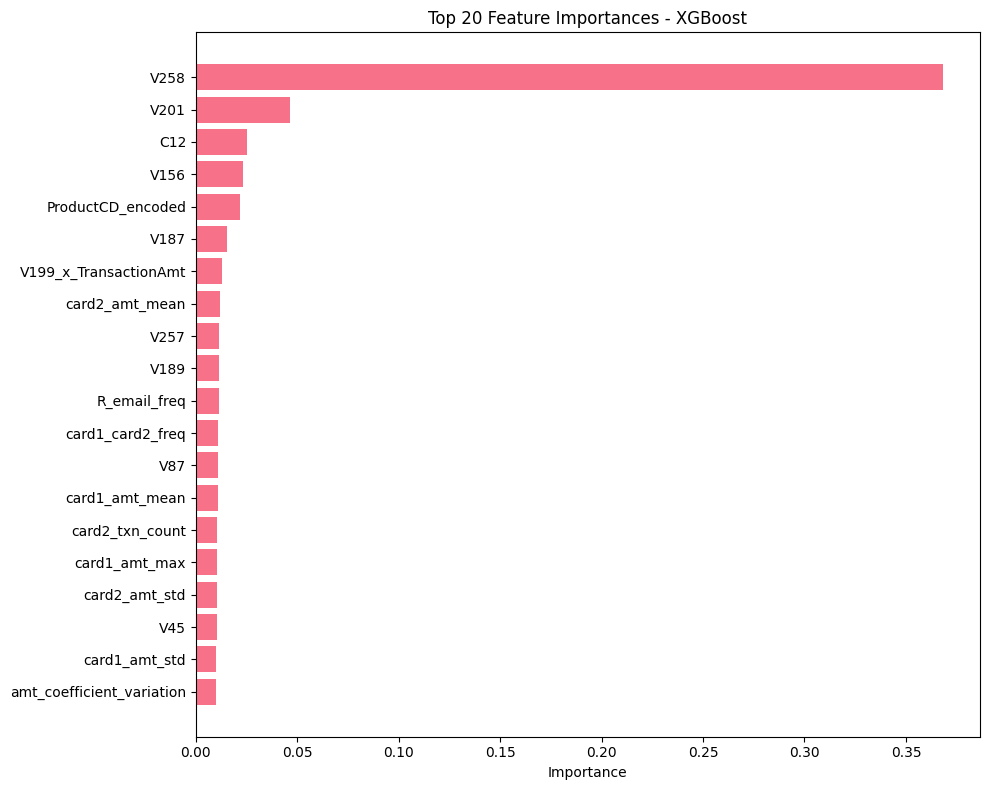

Saved: feature_importance_xgboost.png


In [31]:
print("\n1. Feature Importance - XGBoost")
print("-" * 40)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_tuned.feature_importances_
}).sort_values('Importance', ascending=False).head(20)

plt.figure(figsize=(10, 8))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('visualizations/feature_importance_xgboost.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: feature_importance_xgboost.png")


2. ROC Curves - All Models
----------------------------------------


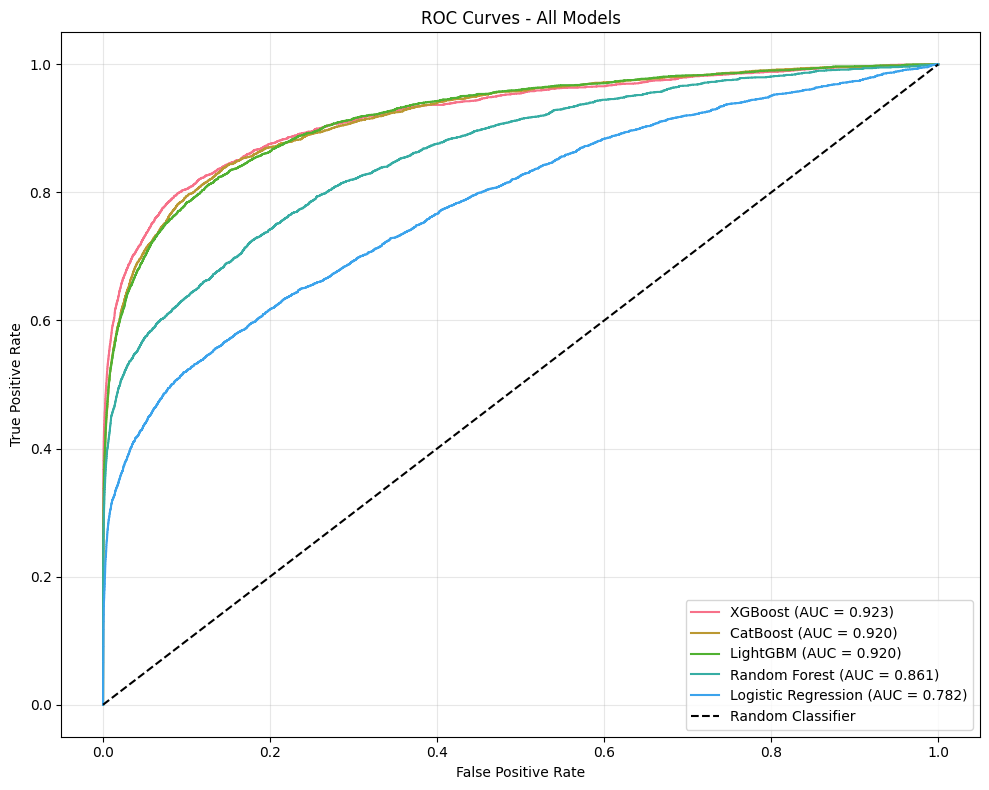

Saved: roc_curves_all_models.png


In [32]:
print("\n2. ROC Curves - All Models")
print("-" * 40)

plt.figure(figsize=(10, 8))

for model_name, y_proba in models_data:
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/roc_curves_all_models.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: roc_curves_all_models.png")


3. Performance Comparison - F1-Score
----------------------------------------


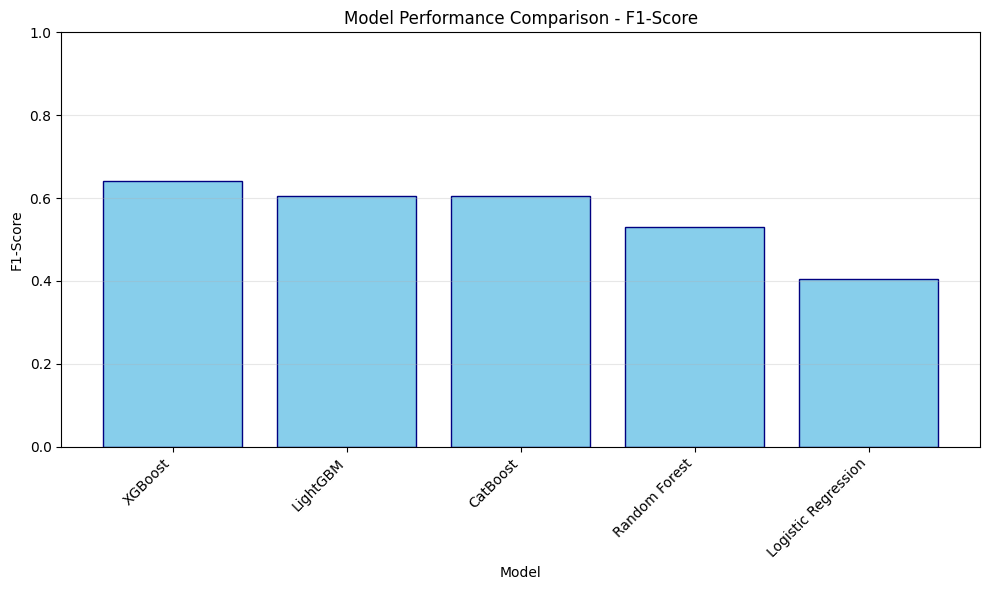

Saved: f1_score_comparison.png


In [33]:
print("\n3. Performance Comparison - F1-Score")
print("-" * 40)

plt.figure(figsize=(10, 6))
plt.bar(final_df['Model'], final_df['F1-Score'], color='skyblue', edgecolor='navy')
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('Model Performance Comparison - F1-Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/f1_score_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: f1_score_comparison.png")


4. Confusion Matrix - Best Model
----------------------------------------


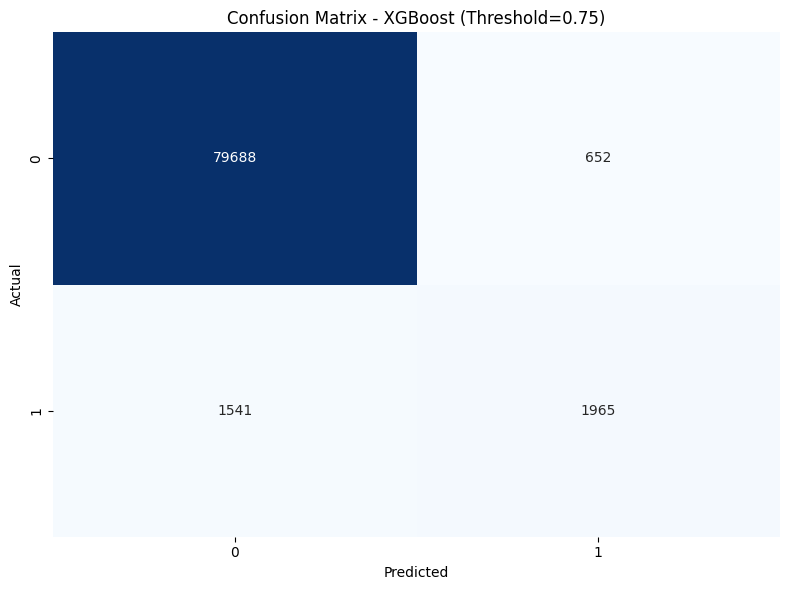

Saved: confusion_matrix_best_model.png


In [34]:
print("\n4. Confusion Matrix - Best Model")
print("-" * 40)

best_model_name = final_df.iloc[0]['Model']
best_threshold = final_df.iloc[0]['Threshold']

if best_model_name == 'XGBoost':
    y_pred_best = (y_pred_proba_xgb_tuned >= best_threshold).astype(int)
elif best_model_name == 'CatBoost':
    y_pred_best = (y_pred_proba_cat_tuned >= best_threshold).astype(int)
elif best_model_name == 'LightGBM':
    y_pred_best = (y_pred_proba_lgbm_tuned >= best_threshold).astype(int)
elif best_model_name == 'Random Forest':
    y_pred_best = (y_pred_proba_rf_tuned >= best_threshold).astype(int)
else:
    y_pred_best = (y_pred_proba_lr_tuned >= best_threshold).astype(int)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name} (Threshold={best_threshold:.2f})')
plt.tight_layout()
plt.savefig('visualizations/confusion_matrix_best_model.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: confusion_matrix_best_model.png")


5. Multi-Metric Comparison
----------------------------------------


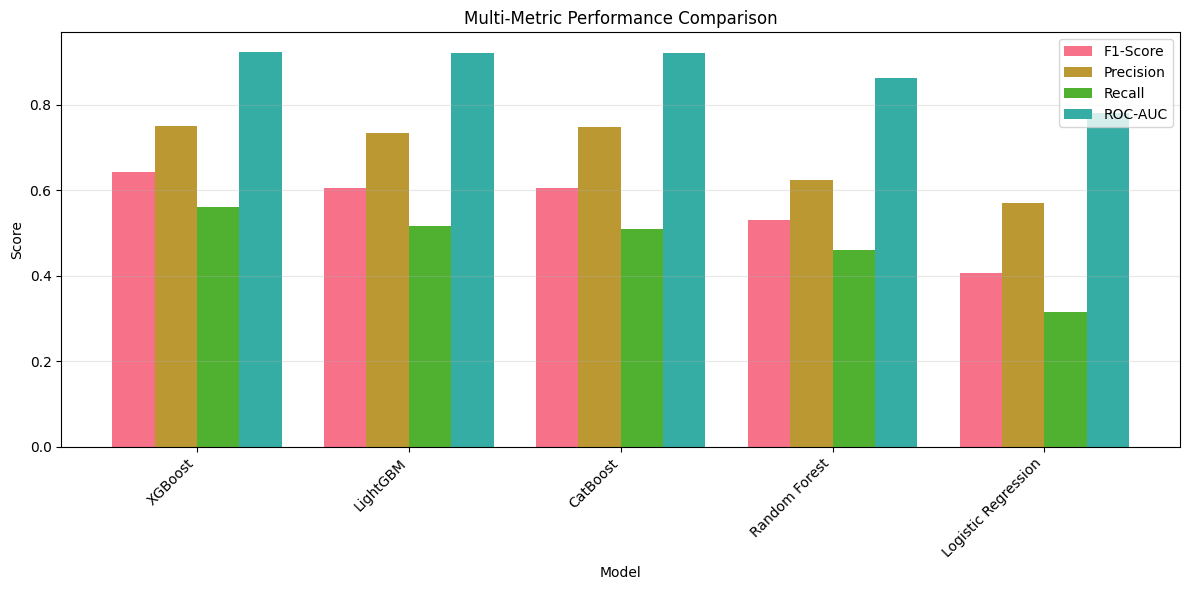

Saved: multi_metric_comparison.png


In [35]:
print("\n5. Multi-Metric Comparison")
print("-" * 40)

metrics = ['F1-Score', 'Precision', 'Recall', 'ROC-AUC']
x = np.arange(len(final_df))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

for i, metric in enumerate(metrics):
    ax.bar(x + i*width, final_df[metric], width, label=metric)

ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Multi-Metric Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(final_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('visualizations/multi_metric_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Saved: multi_metric_comparison.png")

In [36]:
print("\n" + "="*80)
print("PIPELINE COMPLETED SUCCESSFULLY")
print("="*80)

print("\nSummary:")
print(f"  Total features: {X_train.shape[1]}")
print(f"  Training samples: {X_train.shape[0]:,}")
print(f"  Test samples: {X_test.shape[0]:,}")
print(f"  Models trained: 5")
print(f"  Best model: {final_df.iloc[0]['Model']}")
print(f"  Best F1-Score: {final_df.iloc[0]['F1-Score']:.4f}")
print(f"  Best ROC-AUC: {final_df.iloc[0]['ROC-AUC']:.4f}")

print("\nFiles saved:")
print("  Models: models/ (5 models + scaler)")
print("  Results: results/final_results_72features.csv")
print("  Visualizations: visualizations/ (5 plots)")
print("  Metadata: models/model_metadata_72features.json")
print("  Thresholds: models/optimal_thresholds_72features.json")

print("\n" + "="*80)


PIPELINE COMPLETED SUCCESSFULLY

Summary:
  Total features: 71
  Training samples: 335,381
  Test samples: 83,846
  Models trained: 5
  Best model: XGBoost
  Best F1-Score: 0.6418
  Best ROC-AUC: 0.9231

Files saved:
  Models: models/ (5 models + scaler)
  Results: results/final_results_72features.csv
  Visualizations: visualizations/ (5 plots)
  Metadata: models/model_metadata_72features.json
  Thresholds: models/optimal_thresholds_72features.json

